# Preprocessing Notebook 1: Extract published studies

The purpose of this notebook is to take the SU2C data and convert it to a format that can be analyzed for this study.

In [1]:
import umap
import seaborn as sns
import pandas as pd
import numpy as np
from sklearn.pipeline import make_pipeline
import matplotlib.pyplot as plt

2023-08-10 15:05:21.439580: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-08-10 15:05:21.490723: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-08-10 15:05:21.491905: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-08-10 15:05:22.279662: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
# Set random seed so this part is reproducible
# https://www.random.org/ 2023-08-09
np.random.seed(3866)

## Preprocess the clinical data

In [3]:
# First load the original supplementary file from the SU2C publication
clinical = pd.read_excel("../../data/clinical/original/SU2C-MARK_Supplementary_Tables_Combined_v5_Filtered.xlsx", sheet_name=1, header=2)

# Pull out and harmonize and organize it in a pandas DataFrame object
data = []
for i, row in clinical[clinical["Agent_PD1_Category"] == "PD(L)1"].iterrows():
    #print(row)
    
    patient = row.Harmonized_SU2C_Participant_ID_v2
        
    rna = row.Harmonized_SU2C_RNA_Tumor_Sample_ID_v2
        
    wes = row.Harmonized_SU2C_WES_Tumor_Sample_ID_v2
    
    sex = row.Patient_Sex
    
    histology = row.Histology_Harmonized
    
    stage = row.Initial_Stage
    
    line_of_treatment = row.Line_of_Therapy
    
    institution = row.Institution.lower().replace(" ", "_")
    
    pd1_agent = row.Agent_PD1
    
    prior_platinum = row.Prior_Platinum
    
    prior_tki = row.Prior_TKI
    
    bor = row.Harmonized_Confirmed_BOR
    
    data.append((patient, sex, histology, stage, line_of_treatment, rna, wes, institution, pd1_agent, prior_platinum, prior_tki, bor))
    
processed = pd.DataFrame(data=data, 
                         columns=["patient", 
                                  "sex", 
                                  "histology", 
                                  "stage", 
                                  "line_of_treatment", 
                                  "rna", 
                                  "wes", 
                                  "institution", 
                                  "pd1_agent", 
                                  "prior_platinum", 
                                  "prior_tki", 
                                  "bor"])

processed_rna_clinical = processed.dropna(axis=0, subset=["rna"])
processed_rna_clinical.to_csv("../../data/clinical/processed/su2c-rna-clinical.tsv", sep='\t', index=False)

processed_wes_clinical = processed.dropna(axis=0, subset=["wes"])
processed_wes_clinical.to_csv("../../data/clinical/processed/su2c-wes-clinical.tsv", sep='\t', index=False)

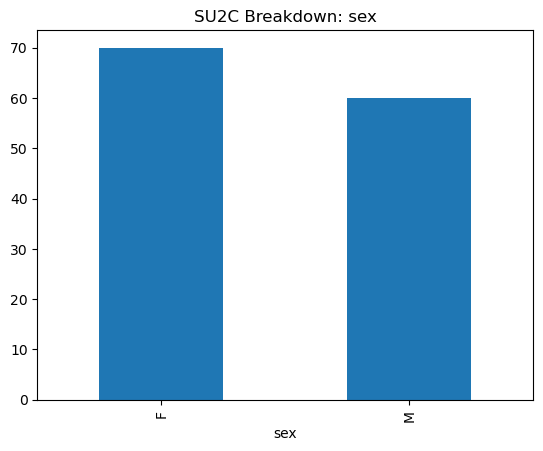

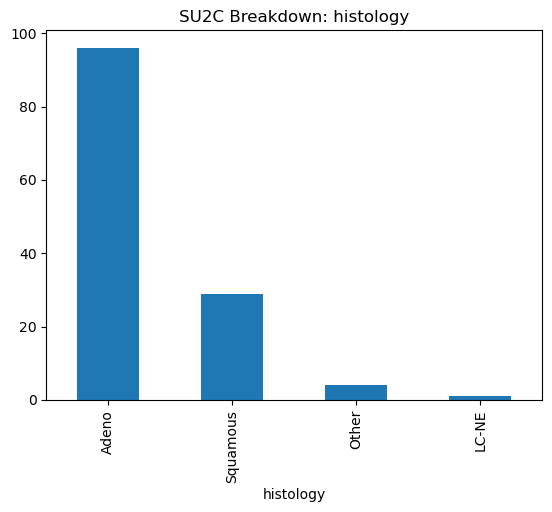

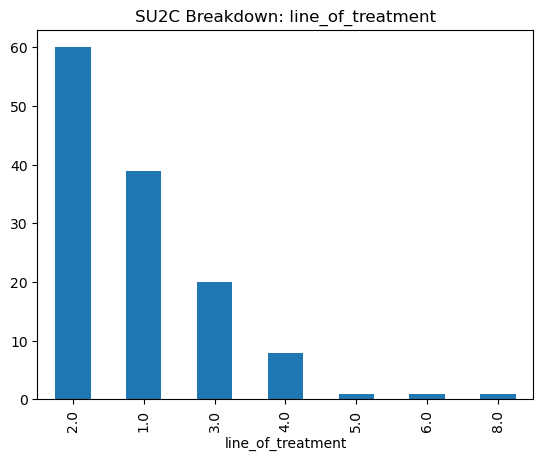

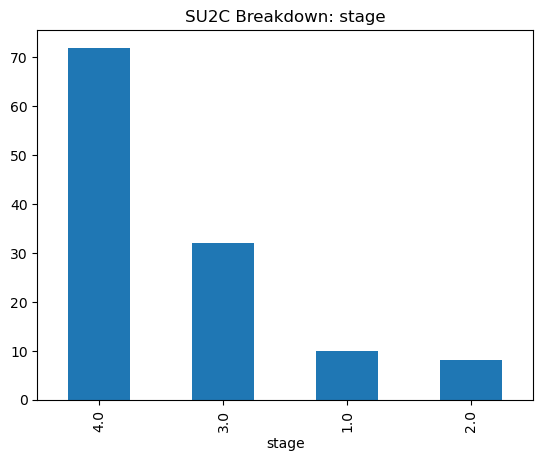

In [4]:
for feature in ["sex", "histology", "line_of_treatment", "stage"]:
    ax = processed_rna_clinical.value_counts(feature).plot(kind='bar')
    plt.title(f"SU2C Breakdown: {feature}")
    plt.show()

## Preprocess the expression data

In [5]:
# Code used to generate the TPM Data
tpm = pd.read_csv("../../data/expression/original/SU2C-MARK_Harmonized_rnaseqc_tpm_v1.gct",
                  sep='\t',
                  header=2,
                  index_col=[0, 1])

tpm = tpm.reset_index().drop("Description", axis=1).set_index("Name")

tpm["ensembl"] = [x.split(".")[0] for x in tpm.index.values]
tpm = tpm.groupby("ensembl").sum()

tpm.to_csv("../../data/expression/processed/SU2C-expression-tpm-ensembl.tsv", sep='\t') 

In [6]:
log2tpm1 = np.log2(tpm + 1.0)

In [7]:
# Filter 
log2tpm1 = log2tpm1.loc[log2tpm1.mean(axis=1) > 1.0, :]

In [8]:
from sklearn.preprocessing import PowerTransformer

# Scale
pipe = make_pipeline(PowerTransformer())
X = pipe.fit_transform(log2tpm1.T.copy())

manifold = umap.UMAP().fit(X)
u = manifold.transform(X)

umapper = umap.UMAP(random_state=999, n_neighbors=30, min_dist=.25)

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


In [9]:
embedding = pd.DataFrame(umapper.fit_transform(log2tpm1.T), columns = ['UMAP1','UMAP2'])

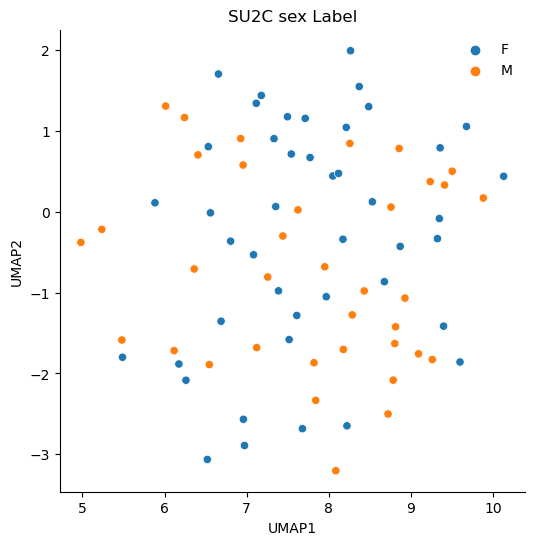

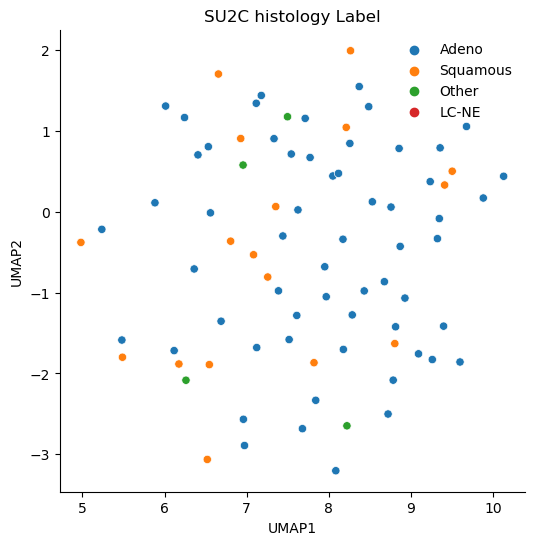

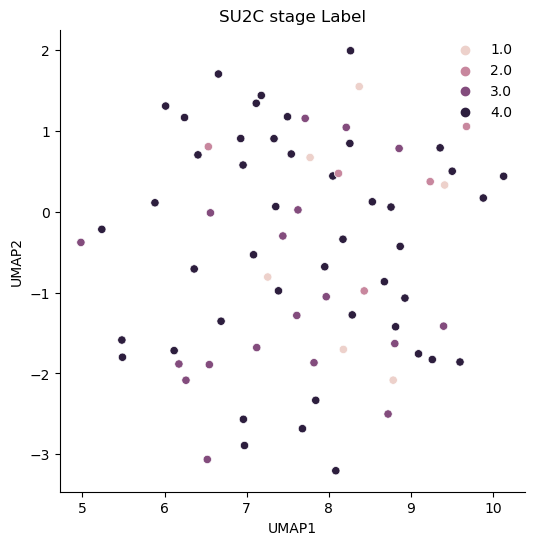

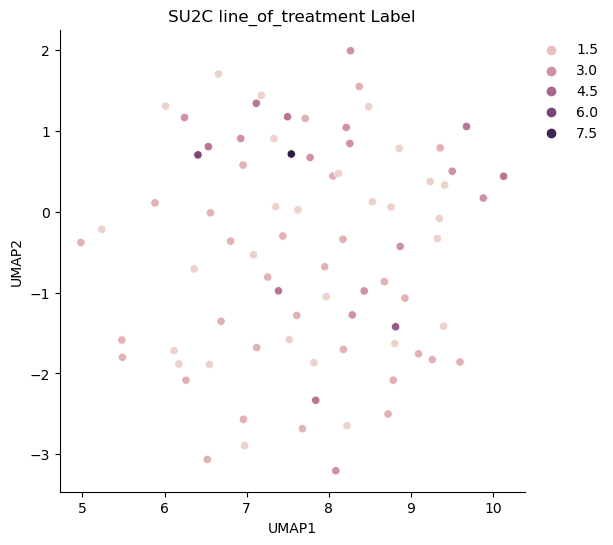

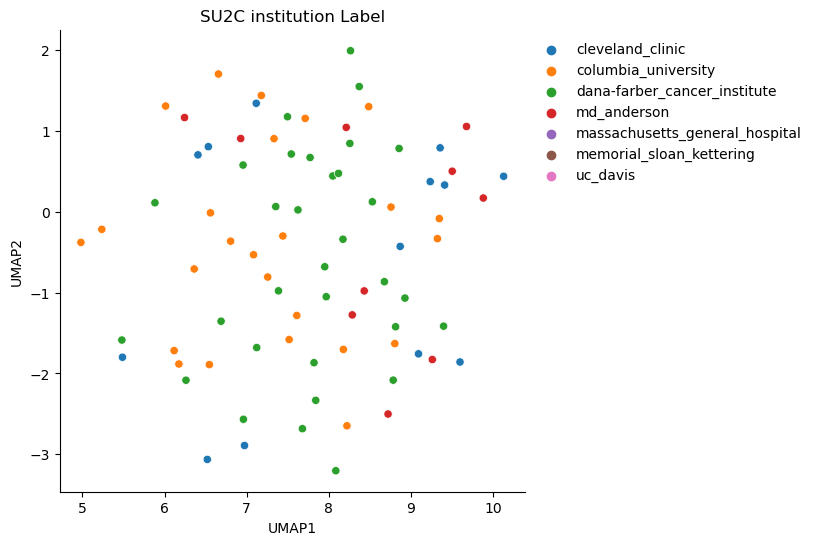

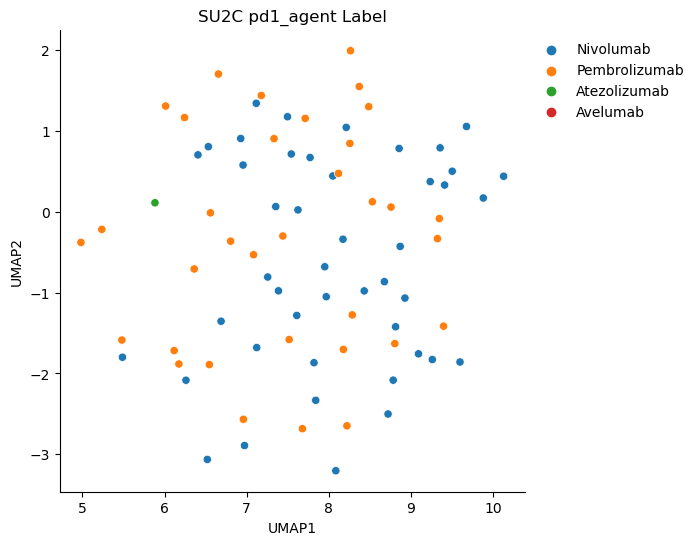

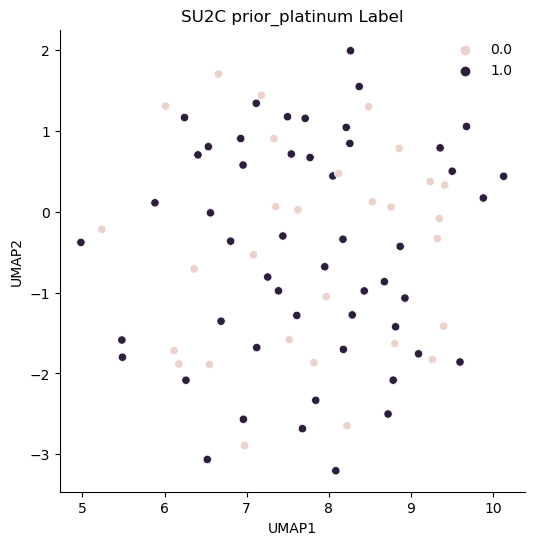

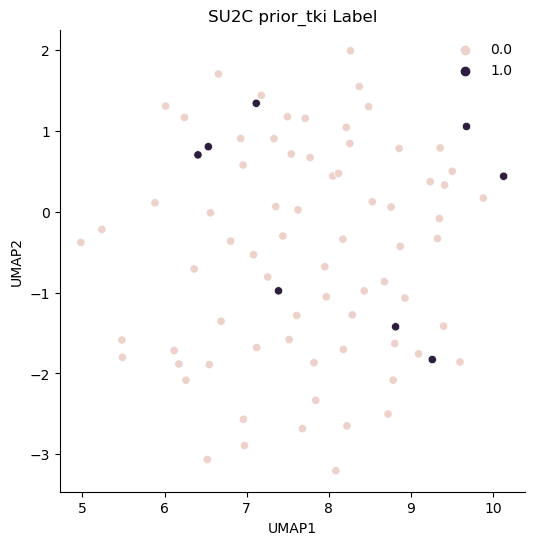

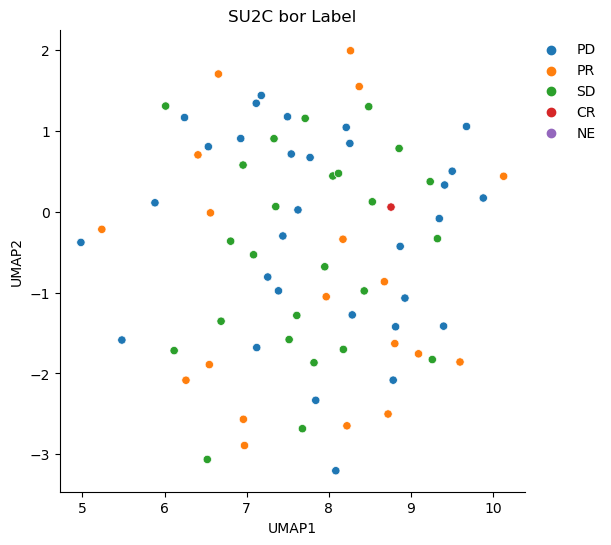

In [10]:


for column in processed_rna_clinical.columns:
    
    if len(processed_rna_clinical[column].unique()) > 8:
        continue

    fig, ax = plt.subplots(1, figsize=(6, 6))

    sns_plot = sns.scatterplot(x='UMAP1', 
                               y='UMAP2', 
                               data=embedding,
                               hue=processed_rna_clinical[column],
                               ax=ax)

    ax.set_title(f"SU2C {column} Label")
    
    plt.legend(bbox_to_anchor=(1.0, 1.0), frameon=False)
    
    sns.despine()

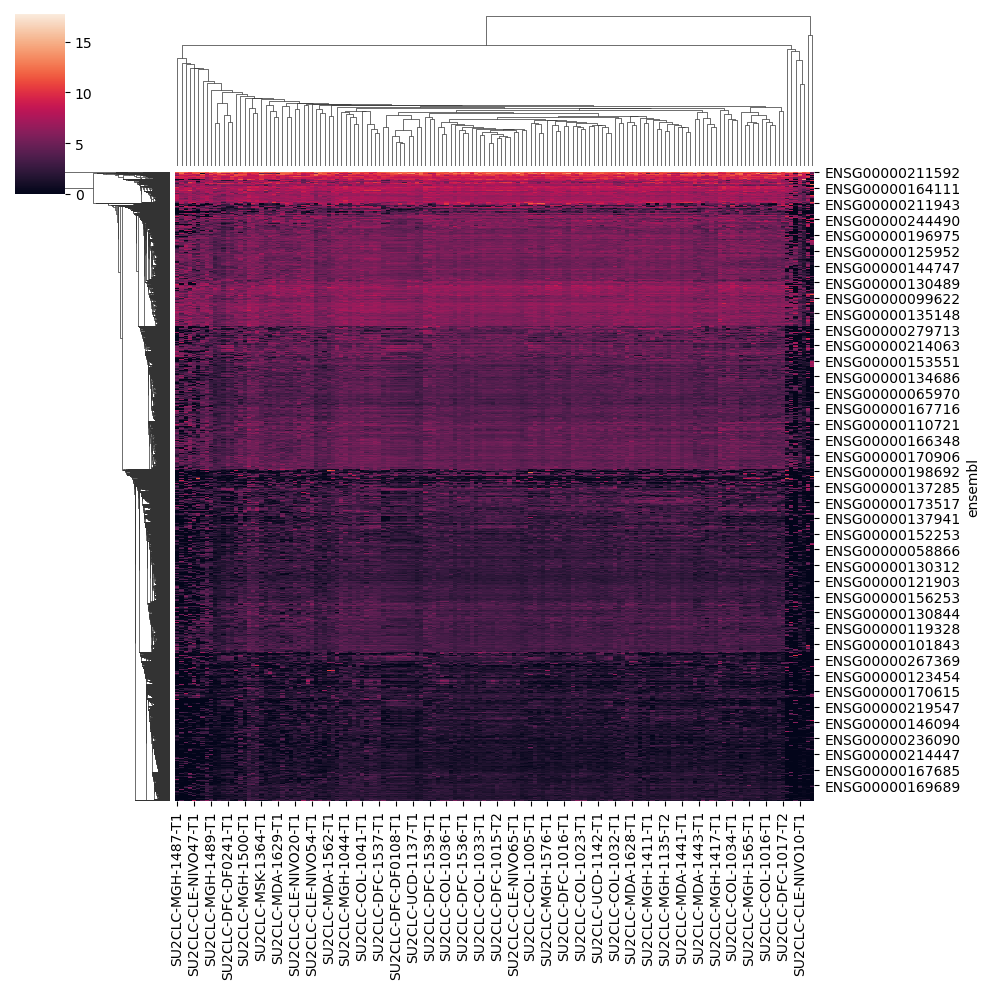

In [11]:
sns.clustermap(log2tpm1)